# Exercise 4 [10.0]

**_DISCLAIMER:_** The notation used in this exercise follows the one of the Probabilistic Robotics book (refer to Chapter 5.4 in case you have doubts).

## 4.1 Inverse motion model [2.0]

The odometry model uses the _relative motion information_. The odometry readings are $u_t = [{\overline{x}}_{t-1} , {\overline{x}}_{t}]$, where $\overline{x}_{t-1}$ and  $\overline{x}_t$ are poses in a robot-internal coordinate frame (different from the map).

The function `inverse_motion_model` takes as input an odometry reading $u_t$ that consist in:

- the initial pose of the robot in the odometry coordinate frame $\overline{x}_{t-1} = [\overline{x},\overline{y},\overline{\theta}]$
- the estimated pose of the robot in the odometry coordinate frame $\overline{x}_t = [\overline{x}',\overline{y}',\overline{\theta}']$

The output is the relative motion $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$.

Implement the function `inverse_motion_model` and verify that it is correct for some test input. 

In [1]:
import ex4 as ex
import numpy as np

# Example 1: Simple forward motion
prev_pose = [0, 0, 0]   # Initial pose
cur_pose = [1, 0, 0]    # Moves 1m forward

print(ex.inverse_motion_model(prev_pose, cur_pose))
# Expected output: (0.0, 1.0, 0.0)

# Example 2: Diagonal movement with rotation
prev_pose = [0, 0, 0]
cur_pose = [1, 1, np.pi/4]

print(ex.inverse_motion_model(prev_pose, cur_pose))
# Expected output: (~0.785, ~1.414, ~0.0) since the motion is diagonal

# Example 3: Backward motion
prev_pose = [2, 2, np.pi]
cur_pose = [1, 2, np.pi]

print(ex.inverse_motion_model(prev_pose, cur_pose))
# Expected output: (0.0, 1.0, 0.0) since it moves backward in a straight line

(0.0, 1.0, 0.0)
(0.7853981633974483, 1.4142135623730951, 0.0)
(0.0, 1.0, 0.0)


## 4.2 Odometry-based motion model [3.0]

The function `motion_model` computes the posterior $p(x_t | u_t, x_{t-1})$ from odometry readings.

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the hypothesized (or query) final pose $x_{t} = [x', y', \theta']$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is the probability $p(x_t | u_t, x_{t-1})$

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [1.0, 1.0, 0.01, 0.01]$.

The robot excecutes one motion command and the odometry readings are:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$

Implement the `motion_model` function and verify that it is correct for some test input. **[1.0]**

---

Consider a 150x150 grid map the world with a resolution of 0.01, centered in the original position of the robot.

Plot the posterior $p(x_t | u_t, x_{t-1})$ for all possible $[x, y]$ values from the grid. **[2.0]**

**Note that** the query input is a position, not a pose. Therefore, to plot the posterior belief over the gridmap, you can assume the term $\hat{\delta}_\mathrm{rot2}$ to be zero and, for each position, integrate over all possible orientations. This can be implemented by considering $p_3 = 1.0$ in the equations. 

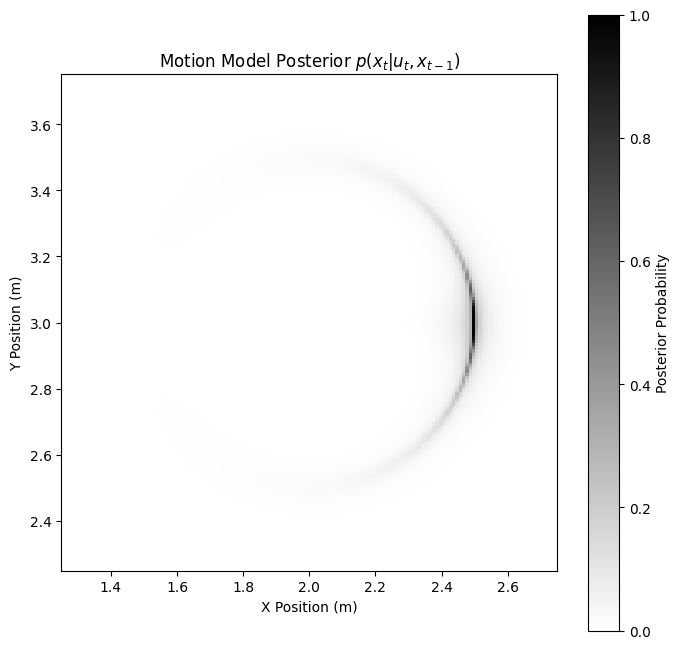

In [1]:
import ex4 as ex
import numpy as np
import matplotlib.pyplot as plt

grid_size = 150
resolution = 0.01
alpha = [1.0, 1.0, 0.01, 0.01]

init_pose = [2.0, 3.0, 0.0]
x0, y0, theta0 = init_pose
odom = ([0.0, 0.0, 0.0], [0.5, 0.0, np.pi/2])

# Define the grid centered at (2.0, 3.0)
x_range = np.linspace(x0 - (grid_size // 2) * resolution, 
                        x0 + (grid_size // 2) * resolution, 
                        grid_size)

y_range = np.linspace(y0 - (grid_size // 2) * resolution, 
                        y0 + (grid_size // 2) * resolution, 
                        grid_size)

posterior = np.zeros((grid_size, grid_size))

# Sample orientations for integration (approximation)
theta_samples = np.linspace(-np.pi, np.pi, 36)  # 36 angles for numerical integration

# Compute probability for each position in the grid
for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        # Compute probability by summing over different theta values
        prob_sum = 0
        for theta in theta_samples:
            prob_sum += ex.motion_model([x, y, theta], [x0, y0, theta0], odom, alpha)
        
        # Approximate integral by averaging
        posterior[j, i] = prob_sum / len(theta_samples)  # Normalize over sampled angles

# Normalize
posterior /= np.max(posterior)

plt.figure(figsize=(8, 8))
plt.imshow(posterior, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], origin='lower', cmap='binary')
plt.colorbar(label="Posterior Probability")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Motion Model Posterior $p(x_t | u_t, x_{t-1})$")
plt.show()

## 4.3 Sample odometry motion model [2.0]

The `motion_model` requires high computation complexity and does not scale well to large real-world environments. 

One effective approach to approximate $p(x_t | u_t, x_{t-1})$ is to use **sampling**.

The `sample_motion_model` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model` function and verify that it is correct for some test input. 

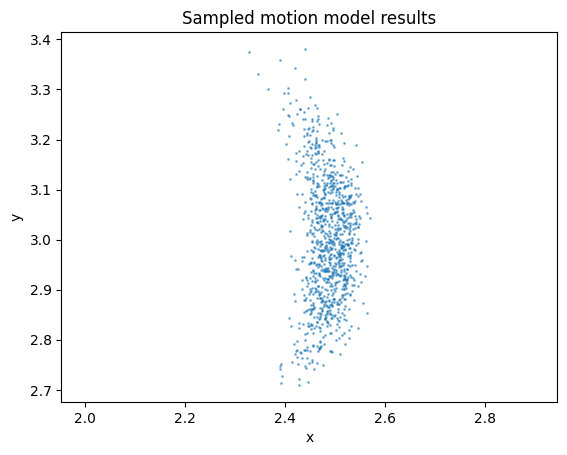

In [1]:
import ex4 as ex
import numpy as np
import matplotlib.pyplot as plt

prev_pose = [2.0, 3.0, 0.0]
odom = [[0.0, 0.0, 0.0], [0.5, 0.0, np.pi/2]]
alpha = [1.0, 1.0, 0.01, 0.01]

samples = [ex.sample_motion_model(prev_pose, odom, alpha) for _ in range(1000)]

import matplotlib.pyplot as plt
samples = np.array(samples)

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sampled motion model results")
plt.axis("equal")
plt.show()

## 4.4 Evaluate sample odometry motion model  [3.0]

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [0.1, 0.1, 0.01, 0.01]$.

The robot obtains the following odometry readings:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$
3. $\overline{x}_2 = [0.5 , 0.5 , 0.0   ]$
4. $\overline{x}_3 = [1.0 , 0.5 , 0.0   ]$
5. $\overline{x}_4 = [1.0 , 1.5 , \pi/2 ]$
6. $\overline{x}_5 = [1.0 , 2.5 , \pi/2 ]$

Evaluate the `sample_motion_model` by considering 1000 samples and plot the resulting positions for each sample in one unique plot.

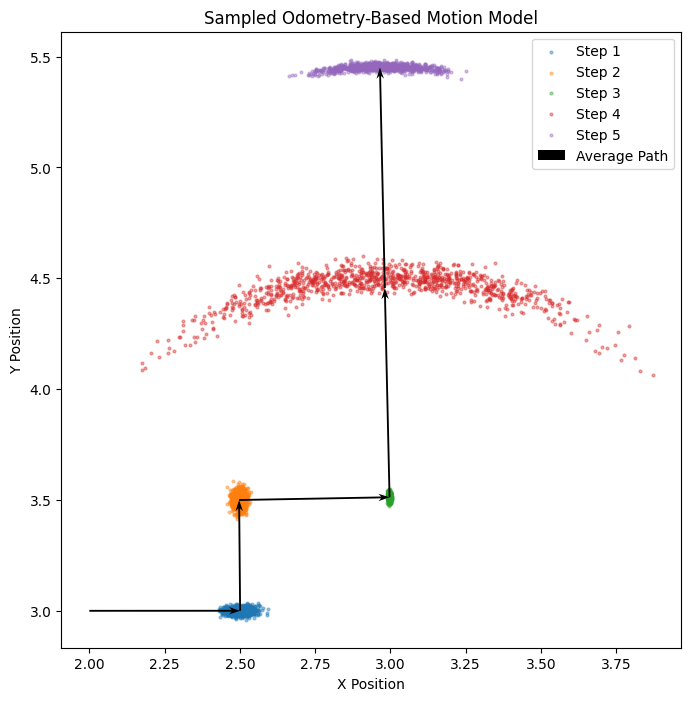

In [7]:
import ex4 as ex
import numpy as np
import matplotlib.pyplot as plt

# Given initial pose and noise parameters
init_pose = np.array([2.0, 3.0, 0.0])
alpha = [0.1, 0.1, 0.01, 0.01]

# Given odometry readings
odoms = [
    [0.0, 0.0, 0.0],
    [0.5, 0.0, np.pi/2],
    [0.5, 0.5, 0.0],
    [1.0, 0.5, 0.0],
    [1.0, 1.5, np.pi/2],
    [1.0, 2.5, np.pi/2]
]

# Number of samples per step
samples = 1000

# Store all samples across time
all_samples = []

# Initialize with initial pose
poses = [init_pose]
mean_poses = [init_pose]  # This will store the mean, noiseless poses

for i in range(len(odoms)-1):
    odom = [odoms[i], odoms[i+1]]
    
    # Sample the noisy motion model
    new_samples = [ex.sample_motion_model(poses[-1], odom, alpha) for _ in range(samples)]
    
    # Append samples to the list for plotting later
    all_samples.append(new_samples)
    
    # Store the mean pose for future iterations (this is the noiseless path)
    mean_pose = np.mean(new_samples, axis=0)  
    poses.append(mean_pose)
    mean_poses.append(mean_pose)  # Add mean pose to the noiseless path

# Plot results
plt.figure(figsize=(8, 8))

# Plot noisy samples
for i, sample_set in enumerate(all_samples):
    x_vals = [s[0] for s in sample_set]
    y_vals = [s[1] for s in sample_set]
    plt.scatter(x_vals, y_vals, s=4, alpha=0.4, label=f"Step {i+1}")

# Plot the noiseless path (line connecting mean poses)
mean_x = [pose[0] for pose in mean_poses]
mean_y = [pose[1] for pose in mean_poses]
plt.quiver(
    mean_x[:-1], mean_y[:-1], 
    np.diff(mean_x), np.diff(mean_y), 
    angles="xy", scale_units="xy", scale=1, 
    color='black', width=0.003, headwidth=4, headlength=6, label="Average Path"
)

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Sampled Odometry-Based Motion Model")
plt.legend()
plt.show()